<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Problem 5: DCGAN, WGAN, WGAN-GP

## Download Data

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz
!pip install wandb
!wandb login

--2024-10-17 16:45:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.134.113, 52.219.170.52, 52.219.208.0, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.134.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  6.44MB/s    in 5.3s    

2024-10-17 16:45:27 (4.76 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-17 16:45:27--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.48, 52.219.170

## Library Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [2]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: NVIDIA A100-SXM4-40GB
GPU Count: 1
GPU Memory Allocated: 0
GPU Memory Cached: 0


## Load Data

### Define FashionMNIST

In [3]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = ((np.copy(imgs) / 255) * 2 - 1).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = F.one_hot(label, num_classes=10).float().to(self.device)
            return img, label
        else:
            return img

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    label = torch.argmax(label)
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset('/content', 'train', device=device)
test = FasionMNISTDataset('/content', 'test', device=device)

traindataloader = DataLoader(torch.utils.data.ConcatDataset([train,test]), batch_size=64, shuffle=True, generator=gen)
# testdataloader = DataLoader(test, batch_size=64, shuffle=True, generator=gen)

In [5]:
len(test)

10000

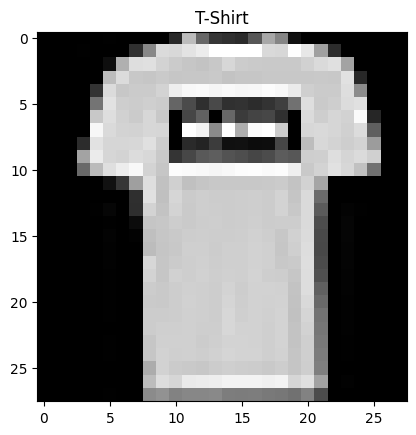

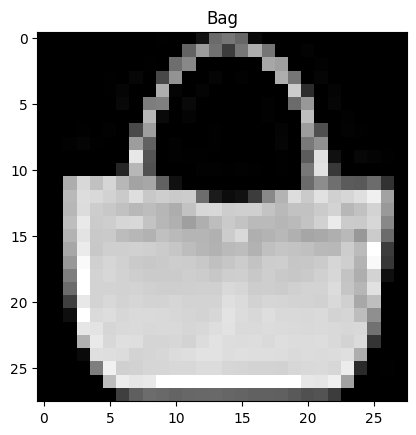

In [6]:
show_img(train, 1)
show_img(train, 100)

## Model Building

### GAN Modules

In [23]:
class Discriminator(nn.Module):
    def __init__(self, model_type, arch_type, channels, num_classes, features):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            # Input: N x (channels + num_classes) x 28 x 28
            nn.Conv2d(channels + num_classes, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2) if model_type != 'gp' else nn.LayerNorm([features * 2, 14, 14]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4) if model_type != 'gp' else nn.LayerNorm([features * 4, 7, 7]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            nn.Conv2d(features * 4, features * 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(features * 8) if model_type != 'gp' else nn.LayerNorm([features * 8, 3, 3]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            nn.Flatten(),
            nn.Linear(features * 8, 1),
            nn.Sigmoid() if model_type == 'dc' else nn.Identity()
        )
        self.apply(self.weights_init)

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        labels = labels.view(batch_size, self.num_classes, 1, 1)
        labels = labels.repeat(1, 1, height, width)
        x = torch.cat((x, labels), dim=1)
        return self.seq(x).view(-1)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, model_type, arch_type, z_dim, num_classes, channels, features):
        super().__init__()
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.seq = nn.Sequential(
            # Project and reshape
            nn.Linear(z_dim + num_classes, features * 8),
            nn.BatchNorm1d(features * 8),
            nn.Unflatten(1, (features * 8, 1, 1)),

            # First upsampling block
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(features * 4) if model_type != 'gp' else nn.LayerNorm([features * 4, 3, 3]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            # Second upsampling block
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(features * 2) if model_type != 'gp' else nn.LayerNorm([features * 2, 7, 7]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            # Third upsampling block
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features) if model_type != 'gp' else nn.LayerNorm([features, 14, 14]),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else nn.Softplus(),

            # Output layer
            nn.ConvTranspose2d(features, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self.weights_init)

    def forward(self, noise, labels):
        batch_size = noise.size(0)
        # labels = labels.view(batch_size, self.num_classes, 1, 1)
        x = torch.cat((noise.squeeze(), labels), dim=1)
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

### DCGAN

In [29]:
class DCGAN:
    def __init__(self, arch_type, z_dim, num_classes, channels, features, device):
        self.z_dim = z_dim
        self.channels = channels
        self.features = features
        self.model_type = 'dc'
        self.arch_type = arch_type
        self.discriminator = Discriminator(self.model_type, arch_type, channels, num_classes, features).to(device)
        self.optim_discrim = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)) #, betas=(0.5, 0.999)
        self.generator = Generator(self.model_type, arch_type, z_dim, num_classes, channels, features).to(device)
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()
        self.device = device

    def train_discriminator(self, real_imgs, real_labels, fake_labels, batch_size):
        self.optim_discrim.zero_grad()

        real_imgs = real_imgs.to(self.device)
        real_labels = real_labels.to(self.device)

        # Train on real images
        output_real = self.discriminator(real_imgs, real_labels).view(-1)
        real_targets = torch.ones_like(output_real)
        real_loss = self.loss(output_real, real_targets)
        real_loss.backward()
        avg_real = output_real.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        output_fake = self.discriminator(fake_imgs.detach(), fake_labels).view(-1)
        fake_targets = torch.zeros_like(output_fake)
        fake_loss = self.loss(output_fake, fake_targets)
        fake_loss.backward()
        avg_fake = output_fake.mean().item()

        discrim_loss = real_loss + fake_loss
        self.optim_discrim.step()

        return fake_imgs, discrim_loss.item(), avg_real, avg_fake


    def train_generator(self, fake_imgs, fake_labels):
        self.optim_gen.zero_grad()
        output = self.discriminator(fake_imgs, fake_labels).view(-1)
        real_targets = torch.ones_like(output)
        gen_loss = self.loss(output, real_targets)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss.item(), output.mean().item()

    def train_one_epoch(self, train_loader, batch_size):
        for i, (real_imgs, real_labels) in enumerate(train_loader):
            current_batch_size = real_imgs.size(0)

            fake_labels = F.one_hot(torch.randint(0, 10, (current_batch_size,), device=self.device), num_classes=10).float()

            fake_imgs, discrim_loss, avg_real, avg_fake1 = self.train_discriminator(real_imgs, real_labels, fake_labels, current_batch_size)
            gen_loss, avg_fake2 = self.train_generator(fake_imgs, fake_labels)

            if i % 100 == 0 and i != 0:
                print(f'[{i}/{len(train_loader)}] DLoss: {discrim_loss:.4f} GLoss: {gen_loss: .4f}, D(x): {avg_real:.4f} D(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}')

            wandb.log({
                "Discriminator Loss": discrim_loss,
                "Generator Loss": gen_loss
            })


    def train(self, traindataloader, epochs, batch_size, noise):
        wandb.init(project='dcgan', config ={
            'epochs': epochs,
            'batch_size': batch_size,
            'noise': noise
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(traindataloader, batch_size)

        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')


In [ ]:
dc = DCGAN('a', 100, 10, 1, 64, device)
dc.train(traindataloader, 10, 64, 100)

----------- DCGAN Train Start! ------------
----------- Epoch #1 ------------
[100/1094] DLoss: 1.1253 GLoss:  1.0727, D(x): 0.6113 D(G(z)): 0.4491/0.3579
[200/1094] DLoss: 1.1890 GLoss:  0.8862, D(x): 0.5702 D(G(z)): 0.4569/0.4153
[300/1094] DLoss: 1.0571 GLoss:  0.9938, D(x): 0.6001 D(G(z)): 0.4077/0.3777
[400/1094] DLoss: 1.1123 GLoss:  0.9294, D(x): 0.5735 D(G(z)): 0.4146/0.4020
[500/1094] DLoss: 1.1587 GLoss:  1.0264, D(x): 0.5670 D(G(z)): 0.4348/0.3677
[600/1094] DLoss: 1.2099 GLoss:  0.9890, D(x): 0.5782 D(G(z)): 0.4626/0.3913
[700/1094] DLoss: 1.1859 GLoss:  0.9274, D(x): 0.5431 D(G(z)): 0.4146/0.4065
[800/1094] DLoss: 1.2448 GLoss:  1.0829, D(x): 0.5086 D(G(z)): 0.4070/0.3543


In [139]:
torch.save(dc.generator.state_dict(), '/content/drive/MyDrive/dc_generator_arch_a.pth')
torch.save(dc.discriminator.state_dict(), '/content/drive/MyDrive/dc_discriminator_archb.pth')

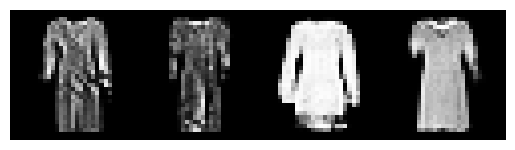

In [142]:
dc.generate_images(4, F.one_hot(torch.tensor([3]*4, device=device), num_classes=10).float())

## WGAN with Clipping


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels, num_classes, filters):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            # Adjust the kernel_size, stride, and padding
            nn.ConvTranspose2d(z_dim + num_classes, filters * 32, kernel_size=4, stride=1, padding=0, bias=False),  # Output: (filters*8, 4, 4)
            nn.BatchNorm2d(filters * 32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters * 32, filters * 16, kernel_size=3, stride=2, padding=1, bias=False),  # Output: (filters*4, 7, 7)
            nn.BatchNorm2d(filters * 16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters * 16, filters * 4, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (filters*2, 14, 14)
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters * 4, channels, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (channels, 28, 28)
            nn.Tanh()
        )
        self.apply(self.weights_init)

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        # print(x.shape)
        # print(labels.shape)
        labels = labels.view(batch_size, self.num_classes, 1, 1)
        x = torch.cat((x, labels), dim=1)
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('ConvTranspose2d') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [7]:
def wasserstein_loss(real_preds, fake_preds):
    return torch.mean(fake_preds) - torch.mean(real_preds)

class Critic(nn.Module):
    def __init__(self, channels, num_classes, filters):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * 28 * 28 + num_classes, filters * 128),
            nn.BatchNorm1d(filters * 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(filters * 128, filters * 64, bias=False),
            nn.BatchNorm1d(filters * 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(filters * 64, 1)
        )
        self.apply(self.weights_init)

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        x = torch.cat((x.view(batch_size, -1), labels), dim=1)
        return self.seq(x)

    # def __init__(self, channels, filters):
    #     super().__init__()
    #     self.seq = nn.Sequential(
    #         # Input: channels x 28 x 28
    #         nn.Conv2d(channels, filters, kernel_size=4, stride=2, padding=1, bias=False),
    #         nn.LeakyReLU(0.2, inplace=True),
    #         # Output: filters x 14 x 14

    #         nn.Conv2d(filters, filters * 2, kernel_size=4, stride=2, padding=1, bias=False),
    #         nn.LayerNorm([filters * 2, 7, 7]),
    #         nn.LeakyReLU(0.2, inplace=True),
    #         # Output: (filters * 2) x 7 x 7

    #         nn.Conv2d(filters * 2, filters * 4, kernel_size=3, stride=1, padding=1, bias=False),
    #         nn.LayerNorm([filters * 4, 7, 7]),
    #         nn.LeakyReLU(0.2, inplace=True),
    #         # Output: (filters * 4) x 7 x 7

    #         nn.Conv2d(filters * 4, filters * 8, kernel_size=3, stride=1, padding=1, bias=False),
    #         nn.LayerNorm([filters * 8, 7, 7]),
    #         nn.LeakyReLU(0.2, inplace=True),
    #         # Output: (filters * 8) x 7 x 7

    #         nn.Flatten(),
    #         nn.Linear(filters * 8 * 7 * 7, 1, bias=False)
    #     )
    #     self.apply(self.weights_init)


    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('LayerNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        elif classname.find('Linear') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)

class WGAN:
    def __init__(self, z_dim, channels, num_classes, features, device, clip_value=0.01, lr=0.00005):
        self.z_dim = z_dim
        self.clip_value = clip_value
        self.lr = lr
        self.device = device

        self.generator = Generator(z_dim, channels, num_classes, features).to(device)
        self.critic = Critic(channels, num_classes, features).to(device)
        self.loss = wasserstein_loss

        self.optim_critic = optim.RMSprop(self.critic.parameters(), lr=lr)
        self.optim_gen = optim.RMSprop(self.generator.parameters(), lr=lr)

    def train_critic(self, real_images, real_labels, fake_labels, batch_size):
        self.optim_critic.zero_grad()

        real_preds = self.critic(real_images, real_labels)

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images.detach(), fake_labels.detach())

        loss = self.loss(real_preds, fake_preds)
        loss.backward()
        self.optim_critic.step()

        for p in self.critic.parameters():
            p.data.clamp_(-self.clip_value, self.clip_value)

        return loss.item(), real_preds.mean().item(), fake_preds.mean().item()

    def train_generator(self, fake_labels, batch_size):
        self.optim_gen.zero_grad()

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images, fake_labels)

        loss = -torch.mean(fake_preds)
        loss.backward()
        self.optim_gen.step()

        return loss.item(), fake_images.mean().item()

    def train_one_epoch(self, dataloader, n_critic=5):
        for i, (real_images, real_labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            d_loss, avg_real, avg_fake1 = self.train_critic(real_images, real_labels, fake_labels, batch_size)

            if i % n_critic == 0:
                g_loss, avg_fake2 = self.train_generator(fake_labels, batch_size)
            else:
                g_loss, avg_fake2 = float('nan'), float('nan')

            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {d_loss:.4f}, Gloss: {g_loss:.4f}, C(x): {avg_real:.4f} C(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}")

            wandb.log({
                "Discriminator Loss": d_loss,
                "Generator Loss": g_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'clip_value': self.clip_value
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')

In [8]:
wgan = WGAN(100, 1, 10, 64, device, lr=0.0001)
wgan.train(traindataloader, 25, 5)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


----------- WGAN Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -0.0306, Gloss: 0.0132, C(x): 0.0211 C(G(z)): -0.0094/-0.1703
Batch 200/1094 Closs: -0.0442, Gloss: 0.0212, C(x): 0.0239 C(G(z)): -0.0203/-0.1467
Batch 300/1094 Closs: -0.0532, Gloss: 0.0320, C(x): 0.0222 C(G(z)): -0.0310/-0.0918
Batch 400/1094 Closs: -0.0473, Gloss: 0.0288, C(x): 0.0237 C(G(z)): -0.0236/-0.0698
Batch 500/1094 Closs: -0.0581, Gloss: 0.0311, C(x): 0.0215 C(G(z)): -0.0365/-0.1308
Batch 600/1094 Closs: -0.0569, Gloss: 0.0350, C(x): 0.0276 C(G(z)): -0.0293/-0.2053
Batch 700/1094 Closs: -0.0576, Gloss: 0.0316, C(x): 0.0239 C(G(z)): -0.0336/-0.0909
Batch 800/1094 Closs: -0.0695, Gloss: 0.0333, C(x): 0.0335 C(G(z)): -0.0360/-0.1738
Batch 900/1094 Closs: -0.0678, Gloss: 0.0284, C(x): 0.0315 C(G(z)): -0.0364/-0.1323
Batch 1000/1094 Closs: -0.0531, Gloss: 0.0254, C(x): 0.0168 C(G(z)): -0.0362/-0.0852
--------------------------------------
----------- Epoch #2 ------------
Batch 100

Discriminator Loss,▂▂▂▃▁▁▃▂▃▄▅▄▄▆▅▄▆▅▆▅▆▆▆▇▅▆▇▅▆▆██▅██▇▇▇█▇
Generator Loss,█ ▁ ▆ ▅ ▆ ▁
Discriminator Loss,-0.02676
Generator Loss,nan


In [10]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/wgan_generator.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/wgan_discriminator.pth')

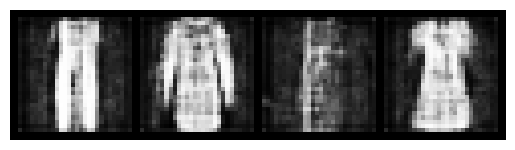

In [14]:
wgan.generator = wgan.generator.to(device)
wgan.critic = wgan.critic.to(device)
lbl = F.one_hot(torch.tensor([3]*4, device=device), num_classes=10).float()
wgan.generator.eval()
with torch.no_grad():  # Disable gradient calculation
    noise = torch.randn(4, 100, 1, 1, device=device)
    generated_images = wgan.generator(noise, lbl)
    # generated_images = (generated_images + 1) / 2
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
    np_grid = grid.permute(1, 2, 0).numpy()
    plt.imshow(np_grid)
    plt.axis('off')

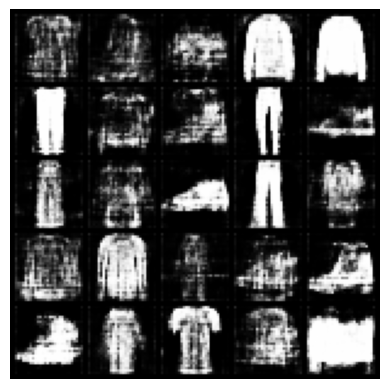

In [13]:
with torch.no_grad():  # Disable gradient calculation
    noise = torch.randn(25, wgan.z_dim, 1, 1, device=wgan.device)
    generated_images = wgan.generator(noise)
    generated_images = (generated_images + 1) / 2
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=5, padding=2, normalize=True)
    np_grid = grid.permute(1, 2, 0).numpy()
    plt.imshow(np_grid)
    plt.axis('off')

## WGAN-GP

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, channels, features):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(
                z_dim + num_classes, features * 4, kernel_size=7, stride=1, padding=0, bias=False
            ),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                features * 4, features * 2, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                features * 2, channels, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        labels = labels.view(batch_size, self.num_classes, 1, 1)
        x = torch.cat((x, labels), dim=1)
        return self.seq(x)


class Critic(nn.Module):
    def __init__(self, num_classes, channels, filters):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * 28 * 28 + num_classes, filters * 128),
            nn.BatchNorm1d(filters * 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(filters * 128, filters * 64, bias=False),
            nn.BatchNorm1d(filters * 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(filters * 64, 1)
        )

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        x = torch.cat((x.view(batch_size, -1), labels), dim=1)
        return self.seq(x)

In [8]:
class WGAN_GP:
    def __init__(self, z_dim, num_classes, channels, features, device, lr=0.0001, lambda_gp=10):
        self.z_dim = z_dim
        self.device = device
        self.lambda_gp = lambda_gp
        self.num_classes = num_classes
        self.lr = lr

        self.generator = Generator(z_dim, num_classes, channels, features).to(device)
        self.critic = Critic(num_classes, channels, features).to(device)

        self.optim_critic = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(0.0, 0.9))
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.0, 0.9))

    def compute_gradient_penalty(self, real_imgs, real_labels, fake_imgs):
        alpha = torch.rand((real_imgs.size(0), 1, 1, 1), device=self.device)
        interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        d_interpolates = self.critic(interpolates, real_labels)
        fake = torch.ones(d_interpolates.size(), device=self.device)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_critic(self, fake_labels, real_imgs, real_labels, batch_size):
        self.optim_critic.zero_grad()
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)

        fake_imgs = self.generator(noise, fake_labels)
        real_preds = self.critic(real_imgs, real_labels)
        fake_preds = self.critic(fake_imgs.detach(), fake_labels)
        gradient_penalty = self.compute_gradient_penalty(real_imgs, real_labels, fake_imgs.detach())
        critic_loss = -torch.mean(real_preds) + torch.mean(fake_preds) + self.lambda_gp * gradient_penalty
        critic_loss.backward()
        self.optim_critic.step()
        return critic_loss

    def train_generator(self, fake_labels):
        self.optim_gen.zero_grad()
        noise = torch.randn(fake_labels.size(0), self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_imgs, fake_labels)
        gen_loss = -torch.mean(fake_preds)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss

    def train_one_epoch(self, dataloader, n_critic):
        gen_loss = None  # Initialize gen_loss
        for i, (real_imgs, real_labels) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            # Train Critic n_critic times
            for _ in range(n_critic):
                critic_loss = self.train_critic(fake_labels, real_imgs, real_labels, batch_size)
            # Train Generator

            gen_loss = self.train_generator(fake_labels)
            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {critic_loss:.4f}, Gloss: {gen_loss:.4f}")

            wandb.log({
                "Critic Loss": critic_loss,
                "Generator Loss": gen_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan-GP', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'lambda_gp': self.lambda_gp
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_samples(self, num_samples, rows):
        with torch.no_grad():
            noise = torch.randn(num_samples, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise)
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=rows, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.figure(figsize=(10, 10))
            plt.imshow(np_grid)
            plt.axis('off')
            plt.show()

In [9]:
wandb.finish()
wgangp = WGAN_GP(100, 10, 1, 64, device)
wgangp.train(traindataloader, 25, 5)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


----------- WGAN_GP Train Start! ------------
----------- Epoch #1 ------------


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Batch 100/1094 Closs: -6.5770, Gloss: 9.4909
Batch 200/1094 Closs: -12.3194, Gloss: 31.4427
Batch 300/1094 Closs: -17.7985, Gloss: 43.4608
Batch 400/1094 Closs: -36.4668, Gloss: 73.3884
Batch 500/1094 Closs: -57.0066, Gloss: 109.1912
Batch 600/1094 Closs: -73.2980, Gloss: 144.3610
Batch 700/1094 Closs: -78.3122, Gloss: 179.7272
Batch 800/1094 Closs: -102.8485, Gloss: 213.2243
Batch 900/1094 Closs: -62.5947, Gloss: 215.9455
Batch 1000/1094 Closs: -92.3334, Gloss: 258.6625
--------------------------------------
----------- Epoch #2 ------------
Batch 100/1094 Closs: -110.9597, Gloss: 293.1976
Batch 200/1094 Closs: -136.2403, Gloss: 381.1513
Batch 300/1094 Closs: -127.1803, Gloss: 424.5729
Batch 400/1094 Closs: -233.9063, Gloss: 512.6887
Batch 500/1094 Closs: -200.5155, Gloss: 570.2384
Batch 600/1094 Closs: -212.3882, Gloss: 636.4426
Batch 700/1094 Closs: -175.4654, Gloss: 693.5220
Batch 800/1094 Closs: -217.5130, Gloss: 800.0394
Batch 900/1094 Closs: -361.1645, Gloss: 925.3530
Batch 1000

KeyboardInterrupt: 

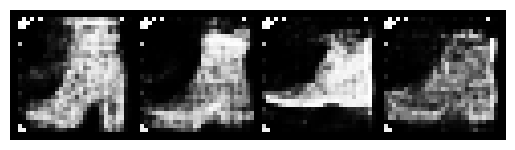

In [13]:
lbl = F.one_hot(torch.tensor([9]*4, device=device), num_classes=10).float()
wgangp.generator.eval()
with torch.no_grad():  # Disable gradient calculation
    noise = torch.randn(4, 100, 1, 1, device=device)
    generated_images = wgangp.generator(noise, lbl)
    # generated_images = (generated_images + 1) / 2
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
    np_grid = grid.permute(1, 2, 0).numpy()
    plt.imshow(np_grid)
    plt.axis('off')

In [14]:
wandb.finish()

Critic Loss,██████████████▇▇█▇▇▆▇█▇▅▇▅▅▆▆▅▄▄▅▅█▁▂▄▃▂
Generator Loss,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▃▄▄▄▅▅▅▆▆▆▇█
Critic Loss,-16106.54688
Generator Loss,39695.04688
